# 데이터 수집


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import os
import shutil

# 압축 파일 경로
zip_path = '/content/drive/MyDrive/DeepLearning/open.zip'

# 압축을 풀 위치 (Colab 임시 저장소)
extract_path = '/content/unzipped_open'

In [ ]:

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료")

압축 해제 완료


In [ ]:
# 압축 파일 삭제 (구글 드라이브에서 삭제됨)
os.remove(zip_path)
print("압축 파일 삭제 완료")

압축 파일 삭제 완료


In [ ]:
# 압축 해제된 파일을 구글 드라이브로 복사
destination_path = '/content/drive/MyDrive/DeepLearning/unzipped_open'
shutil.copytree(extract_path, destination_path)

print("압축 해제된 파일 드라이브에 저장 완료")

압축 해제된 파일 드라이브에 저장 완료


# EDA 및 데이터 전처리


In [ ]:
import os

directory_path = '/content/drive/MyDrive/DeepLearning/unzipped_open/open/train'
files = os.listdir(directory_path)

print("디렉터리 내 폴더 목록:")
for f in files:
    print(f)

디렉터리 내 폴더 목록:
Mud_Sandstone
Granite
Basalt
Gneiss
Etc
Andesite
Weathered_Rock


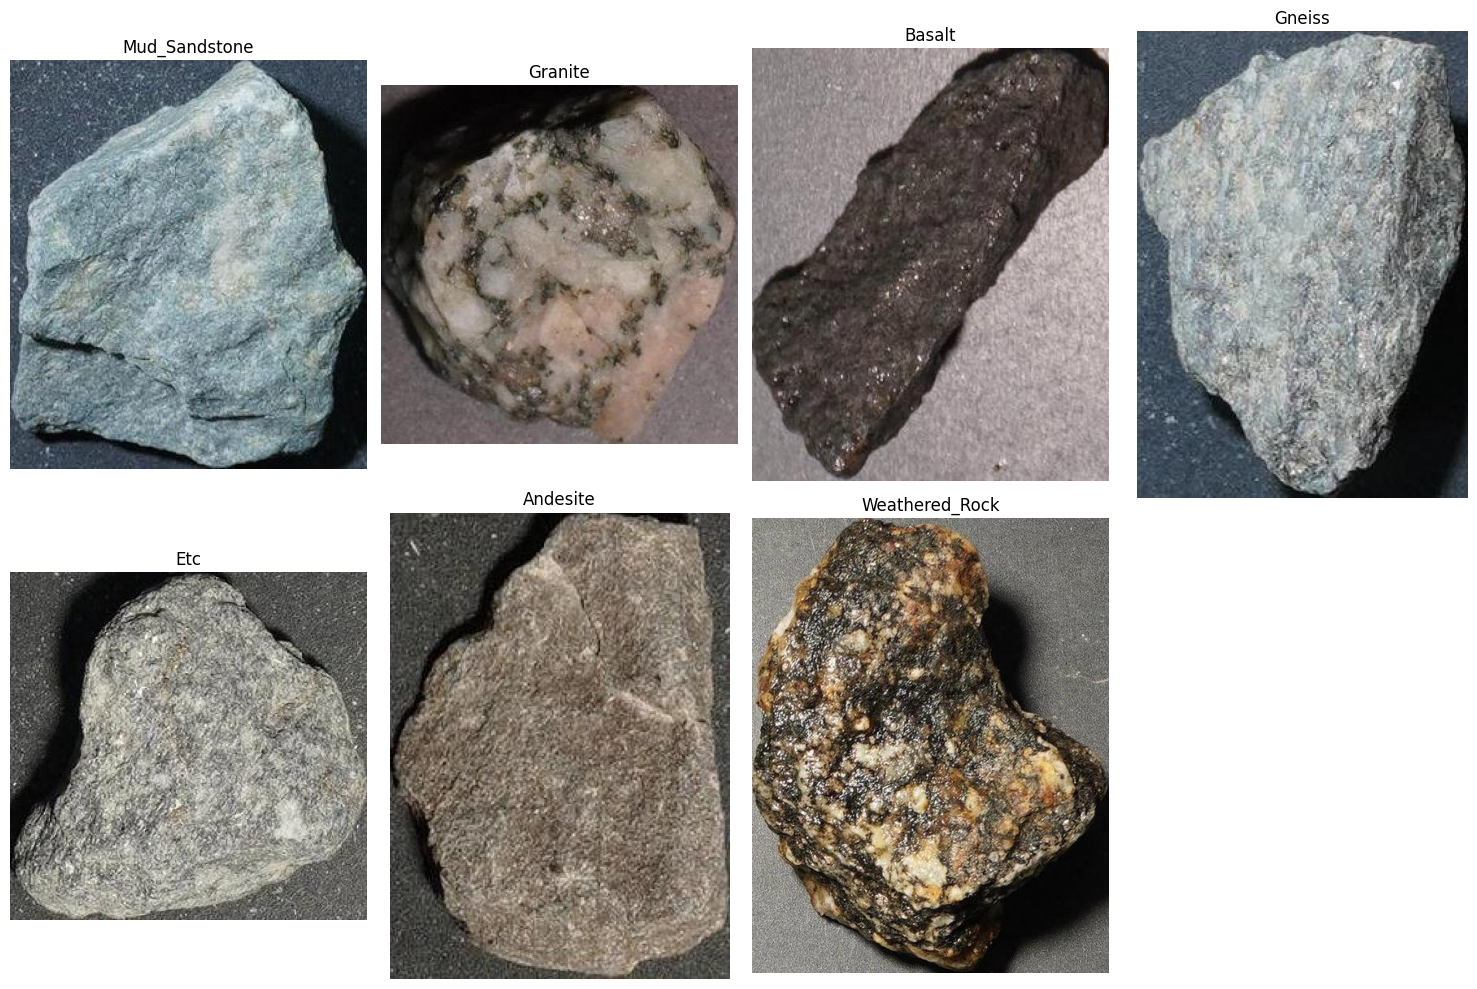

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 클래스 디렉터리가 있는 경로
train_dir = '/content/drive/MyDrive/DeepLearning/unzipped_open/open/train'

# 클래스 이름 목록
classes = os.listdir(train_dir)

# 시각화
plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    img_files = os.listdir(class_path)

    if not img_files:
        continue

    img_path = os.path.join(class_path, img_files[0])  # 첫 번째 이미지

    # 이미지 불러오기 및 시각화
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


# 정규화 및 이미지 증강

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # 암석은 어느 방향에서도 관찰 가능하므로 회전 허용
    width_shift_range=0.1,       # 위치 이동
    height_shift_range=0.1,
    zoom_range=0.2,              # 확대/축소로 다양한 거리에서의 관찰 효과
    horizontal_flip=True,        # 좌우 대칭
    vertical_flip=True,          # 상하 대칭도 가능 (암석은 상하 의미가 없음)
    shear_range=0.1,             # 경사 변형
    fill_mode='nearest',         # 빈 공간 채움
    validation_split=0.2  # 검증 데이터로 20% 사용
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/DeepLearning/unzipped_open/open/train',
    target_size=(128, 128), # 학습 속도가 너무 느려서 이미지 줄였었는데 이거 나중에 조절
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

Found 304019 images belonging to 7 classes.


In [ ]:

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/DeepLearning/unzipped_open/open/train',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 76001 images belonging to 7 classes.


# 모델링

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/DeepLearning/unzipped_open/open/test.csv",encoding='UTF-8')
df_submit = pd.read_csv("/content/drive/MyDrive/DeepLearning/unzipped_open/open/sample_submission.csv",encoding='UTF-8')

In [ ]:
df_test.head()

,ID,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [ ]:
df_submit.head()

,ID,rock_type
0,TEST_00000,Etc
1,TEST_00001,Etc
2,TEST_00002,Etc
3,TEST_00003,Etc
4,TEST_00004,Etc


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from tqdm import tqdm
import cv2

In [ ]:
train_path = '/content/drive/MyDrive/DeepLearning/unzipped_open/open/train'
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)
print("클래스:", class_names)
print("클래스 수:", num_classes)

클래스: ['Andesite', 'Basalt', 'Etc', 'Gneiss', 'Granite', 'Mud_Sandstone', 'Weathered_Rock']
클래스 수: 7


In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

resnet_base.trainable = False  # 학습 초반엔 ResNet의 가중치를 고정

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    batch_size=16
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
  967/19002 ━━━━━━━━━━━━━━━━━━━━ 8:32:25 2s/step - accuracy: 0.2404 - loss: 1.8464

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import f1_score

# 예측값 생성
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# 실제 레이블
y_true_labels = val_generator.classes

# macro F1 score 계산
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
print(f"Macro F1 Score (Validation): {f1:.4f}")


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/DeepLearning/unzipped_open/open/test.csv')
test_images = []

for path in tqdm(test_df['img_path']):
    img_path = os.path.join('/content/drive/MyDrive/DeepLearning/unzipped_open/open', path[2:])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    test_images.append(img)

X_test = np.array(test_images)

# 성능 평가